<a href="https://colab.research.google.com/github/mymph/rn-atividade2/blob/main/treinamento-mlp-atividade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install nba_api optuna

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from nba_api.stats.endpoints import leaguegamefinder
warnings.filterwarnings('ignore')

In [ ]:
# ID do Boston Celtics
TEAM_ID = 1610612738

# Coletar dados da temporada
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=TEAM_ID, season_nullable='2024-25')
df = gamefinder.get_data_frames()[0]

print("Dados carregados:")
print(f"Shape: {df.shape}")
print(df.head())

Dados carregados:
Shape: (98, 28)
  SEASON_ID     TEAM_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  \
0     42024  1610612738               BOS  Boston Celtics  0042400216   
1     42024  1610612738               BOS  Boston Celtics  0042400215   
2     42024  1610612738               BOS  Boston Celtics  0042400214   
3     42024  1610612738               BOS  Boston Celtics  0042400213   
4     42024  1610612738               BOS  Boston Celtics  0042400212   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  REB  AST  \
0  2025-05-16    BOS @ NYK  L  241   81  ...   0.700     9    27   36   19   
1  2025-05-14  BOS vs. NYK  W  242  127  ...   0.654    12    32   44   27   
2  2025-05-12    BOS @ NYK  L  241  113  ...   0.731     7    24   31   15   
3  2025-05-10    BOS @ NYK  W  242  115  ...   0.882    12    30   42   23   
4  2025-05-07  BOS vs. NYK  L  240   90  ...   0.800    16    35   51   17   

   STL  BLK  TOV  PF  PLUS_MINUS  
0    4    3   15  22   

In [ ]:
df["GAME_DATE"] = pd.to_datetime(df["GAME_DATE"])
df = df.sort_values("GAME_DATE")

# Renomear colunas (igual à atividade 1)
df = df.rename(columns={
    "GAME_DATE": "Data do Jogo",
    "MATCHUP": "Confronto",
    "WL": "Vitória/Derrota",
    "PTS": "Pontos",
    "REB": "Rebotes",
    "AST": "Assistências",
    "FGM": "Arremessos Convertidos",
    "FGA": "Arremessos Tentados",
    "FG_PCT": "Percentual de Arremesso",
    "FG3M": "Cestas de 3 Convertidas",
    "FG3A": "Cestas de 3 Tentativas",
    "FG3_PCT": "Percentual de 3 Pontos",
    "FTM": "Lances Livres Convertidos",
    "FTA": "Lances Livres Tentados",
    "FT_PCT": "Percentual de Lances Livres",
    "OREB": "Rebotes Ofensivos",
    "DREB": "Rebotes Defensivos",
    "STL": "Roubos de Bola",
    "BLK": "Tocos",
    "TOV": "Erros (Turnovers)",
    "PF": "Faltas",
    "PLUS_MINUS": "+/-"
})

# Processar coluna 'Confronto' para extrair informações úteis: adversário e se é em casa/fora
def processar_confronto(confronto):
    if 'vs.' in confronto:
        return 'Casa', confronto.split('vs. ')[1].strip()
    elif '@' in confronto:
        return 'Fora', confronto.split('@ ')[1].strip()
    else:
        return 'Neutro', 'Desconhecido'

# Aplicar processamento
df[['Local', 'Adversario']] = df['Confronto'].apply(
    lambda x: pd.Series(processar_confronto(x))
)

# Codificar adversários (transformar em números)
le_adversario = LabelEncoder()
df['Adversario_Encoded'] = le_adversario.fit_transform(df['Adversario'])

# Codificar local (Casa=1, Fora=0, Neutro=0.5)
df['Local_Encoded'] = df['Local'].map({'Casa': 1, 'Fora': 0, 'Neutro': 0.5})

print(f"Adversários únicos encontrados: {len(le_adversario.classes_)}")
print(f"Distribuição de local: {df['Local'].value_counts().to_dict()}")

Adversários únicos encontrados: 30
Distribuição de local: {'Fora': 49, 'Casa': 49}


In [ ]:
# Definir features iniciais (REMOVENDO as que não fazem sentido)
features_nao_permitidas = ["SEASON_ID", "TEAM_ID", "TEAM_ABBREVIATION", "TEAM_NAME", "GAME_ID", "Data do Jogo", "Confronto", "Local", "Adversario"]

# Todas as colunas numéricas disponíveis
todas_colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Filtrar apenas as que fazem sentido para o modelo
features_mlp = [col for col in todas_colunas_numericas if col not in features_nao_permitidas]

# Adicionar as features processadas do confronto
features_mlp.extend(['Local_Encoded', 'Adversario_Encoded'])
features_mlp = list(set(features_mlp))

print(f"\nFeatures selecionadas para MLP ({len(features_mlp)}):")
for i, feature in enumerate(features_mlp, 1):
    print(f"  {i:2d}. {feature}")


Features selecionadas para MLP (22):
   1. Faltas
   2. Tocos
   3. MIN
   4. Arremessos Tentados
   5. Rebotes Ofensivos
   6. Erros (Turnovers)
   7. Cestas de 3 Convertidas
   8. Roubos de Bola
   9. Percentual de 3 Pontos
  10. Percentual de Arremesso
  11. Lances Livres Tentados
  12. Cestas de 3 Tentativas
  13. Rebotes
  14. Arremessos Convertidos
  15. Local_Encoded
  16. Adversario_Encoded
  17. Pontos
  18. Percentual de Lances Livres
  19. +/-
  20. Assistências
  21. Rebotes Defensivos
  22. Lances Livres Convertidos


In [ ]:
# Preparar target
df['TARGET'] = df['Vitória/Derrota'].map({'W': 1, 'L': 0})

print(f"\nDistribuição do target:")
print(df['Vitória/Derrota'].value_counts())
print(f"Total de jogos: {len(df)}")


Distribuição do target:
Vitória/Derrota
W    71
L    27
Name: count, dtype: int64
Total de jogos: 98


In [ ]:
# split
X = df[features_mlp]
y = df['TARGET']

# treino+validação vs teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nShapes finais:")
print(f"  Treino: {X_train_scaled.shape}")
print(f"  Validação: {X_val_scaled.shape}")
print(f"  Teste: {X_test_scaled.shape}")

# Salvar o scaler
joblib.dump(scaler, 'scaler_mlp.pkl')
print("Scaler salvo: scaler_mlp.pkl")

# Salvar dados processados
df.to_csv("celtics_2024_25_processado.csv", index=False)
print("Dados processados salvos: celtics_2024_25_processado.csv")


Shapes finais:
  Treino: (54, 22)
  Validação: (14, 22)
  Teste: (30, 22)
Scaler salvo: scaler_mlp.pkl
Dados processados salvos: celtics_2024_25_processado.csv


In [ ]:
# Optuna: função obetivo com feature selection
def objective_with_feature_selection(trial):

    # feature selection
    selected_features = []
    for feature in features_mlp:
        if trial.suggest_categorical(f'feature_{feature}', [True, False]):
            selected_features.append(feature)

    # Penalizar se não selecionou nenhuma feature
    if len(selected_features) == 0:
        return float('inf')

    # Criar subconjuntos com features selecionadas
    feature_indices = [features_mlp.index(f) for f in selected_features]
    X_train_subset = X_train_scaled[:, feature_indices]
    X_val_subset = X_val_scaled[:, feature_indices]

    # hiperparâmetros da arquitetura
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = []

    for i in range(n_layers):
        units.append(trial.suggest_int(f'n_units_layer_{i}', 8, 64))  # diminuí neurônios para evitar overfitting

    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # construção do modelo
    model = tf.keras.Sequential()

    # Camada de entrada
    model.add(tf.keras.layers.Dense(
        units[0],
        activation=activation,
        input_shape=(len(selected_features),)
    ))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camadas ocultas
    for i in range(1, n_layers):
        model.add(tf.keras.layers.Dense(units[i], activation=activation))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camada de saída
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=0
    )

    # treino optuna
    history = model.fit(
        X_train_subset, y_train,
        epochs=80,
        batch_size=batch_size,
        validation_data=(X_val_subset, y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # avaliação
    val_loss = min(history.history['val_loss'])
    trial.set_user_attr("selected_features", selected_features)
    trial.set_user_attr("n_features", len(selected_features))

    print(f"\n[SUMMARY] Trial {trial.number}:")
    print(f"  Features: {len(selected_features)} | Arch: {units}")
    print(f"  Act: {activation} | Opt: {optimizer_name} | LR: {learning_rate:.6f}")
    print(f"  Val Loss: {val_loss:.4f}")

    return val_loss

In [ ]:
# executar otimização
study_with_fs = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(seed=42)
)
study_with_fs.optimize(objective_with_feature_selection, n_trials=50)

# resultados
print("Otimização concluída!")
print(f"Melhor val_loss: {study_with_fs.best_value:.4f}")

# Features selecionadas
best_features = [
    feature for feature in features_mlp
    if study_with_fs.best_trial.params.get(f'feature_{feature}', False)
]

print(f"Features selecionadas ({len(best_features)}):")
for i, feature in enumerate(best_features, 1):
    print(f"  {i:2d}. {feature}")

[I 2025-11-14 02:20:00,665] A new study created in memory with name: no-name-552ffc9f-d417-4d95-9793-bb8b2fe4cc72
[I 2025-11-14 02:20:24,718] Trial 0 finished with value: 0.29328465461730957 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 1, 'n_units_layer_0': 45, 'd


[SUMMARY] Trial 0:
  Features: 10 | Arch: [45]
  Act: elu | Opt: rmsprop | LR: 0.001097
  Val Loss: 0.2933


[I 2025-11-14 02:20:34,036] Trial 1 finished with value: 0.6356114149093628 and parameters: {'feature_Faltas': True, 'feature_Tocos': False, 'feature_MIN': False, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': False, 'feature_+/-': False, 'feature_Assistências': False, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': True, 'n_layers': 2, 'n_units_layer_0': 25, 'n_units_layer_1': 36, 'dropout_rate': 0.6630265895704371, 'learning_rate': 0.00031519872951938895, 'activation': 'tan


[SUMMARY] Trial 1:
  Features: 11 | Arch: [25, 36]
  Act: tanh | Opt: rmsprop | LR: 0.000315
  Val Loss: 0.6356


[I 2025-11-14 02:20:42,705] Trial 2 finished with value: 0.6871716380119324 and parameters: {'feature_Faltas': True, 'feature_Tocos': False, 'feature_MIN': False, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': False, 'feature_+/-': True, 'feature_Assistências': False, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': True, 'n_layers': 3, 'n_units_layer_0': 28, 'n_units_layer_1': 44, 'n_units_layer_2': 44, 'dropout_rate': 0.5143098736299033, 'learning_rate': 0.00015155823539597


[SUMMARY] Trial 2:
  Features: 11 | Arch: [28, 44, 44]
  Act: relu | Opt: sgd | LR: 0.000152
  Val Loss: 0.6872


[I 2025-11-14 02:20:50,878] Trial 3 finished with value: 0.537922203540802 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': False, 'feature_+/-': False, 'feature_Assistências': True, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 56, 'n_units_layer_1': 45, 'dropout_rate': 0.5273234413341886, 'learning_rate': 0.00015393931002140855, 'activation': 'relu',


[SUMMARY] Trial 3:
  Features: 13 | Arch: [56, 45]
  Act: relu | Opt: adam | LR: 0.000154
  Val Loss: 0.5379


[I 2025-11-14 02:20:59,458] Trial 4 finished with value: 0.6039183735847473 and parameters: {'feature_Faltas': True, 'feature_Tocos': False, 'feature_MIN': True, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': False, 'feature_+/-': True, 'feature_Assistências': False, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': True, 'n_layers': 3, 'n_units_layer_0': 45, 'n_units_layer_1': 48, 'n_units_layer_2': 53, 'dropout_rate': 0.6560021367270265, 'learning_rate': 0.00047423140811121


[SUMMARY] Trial 4:
  Features: 11 | Arch: [45, 48, 53]
  Act: elu | Opt: sgd | LR: 0.000474
  Val Loss: 0.6039


[I 2025-11-14 02:21:07,995] Trial 5 finished with value: 0.34603843092918396 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': False, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': True, 'n_layers': 1, 'n_units_layer_0': 56, 'dropout_rate': 0.5814631437520095, 'learning_rate': 0.0008878664758716851, 'activation': 'tanh', 'optimizer': 'rmspro


[SUMMARY] Trial 5:
  Features: 12 | Arch: [56]
  Act: tanh | Opt: rmsprop | LR: 0.000888
  Val Loss: 0.3460


[I 2025-11-14 02:21:10,761] Trial 6 finished with value: 0.46730485558509827 and parameters: {'feature_Faltas': False, 'feature_Tocos': False, 'feature_MIN': True, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': False, 'feature_+/-': False, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': True, 'n_layers': 2, 'n_units_layer_0': 52, 'n_units_layer_1': 27, 'dropout_rate': 0.6723029302414258, 'learning_rate': 0.005209853409855873, 'activation': 'elu


[SUMMARY] Trial 6:
  Features: 10 | Arch: [52, 27]
  Act: elu | Opt: rmsprop | LR: 0.005210
  Val Loss: 0.4673


[I 2025-11-14 02:21:19,091] Trial 7 finished with value: 0.7125554084777832 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': False, 'feature_+/-': True, 'feature_Assistências': False, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': True, 'n_layers': 3, 'n_units_layer_0': 39, 'n_units_layer_1': 32, 'n_units_layer_2': 59, 'dropout_rate': 0.34447899292246054, 'learning_rate': 0.0009666076069077


[SUMMARY] Trial 7:
  Features: 11 | Arch: [39, 32, 59]
  Act: tanh | Opt: sgd | LR: 0.000967
  Val Loss: 0.7126


[I 2025-11-14 02:21:27,406] Trial 8 finished with value: 0.6179813742637634 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': False, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 3, 'n_units_layer_0': 42, 'n_units_layer_1': 31, 'n_units_layer_2': 61, 'dropout_rate': 0.6464255558001633, 'learning_rate': 0.0001231508291526038,


[SUMMARY] Trial 8:
  Features: 14 | Arch: [42, 31, 61]
  Act: elu | Opt: adam | LR: 0.000123
  Val Loss: 0.6180


[I 2025-11-14 02:21:37,245] Trial 9 finished with value: 0.17814227938652039 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 3, 'n_units_layer_0': 27, 'n_units_layer_1': 37, 'n_units_layer_2': 52, 'dropout_rate': 0.45861711292850804, 'learning_rate': 0.0017545809123068


[SUMMARY] Trial 9:
  Features: 12 | Arch: [27, 37, 52]
  Act: tanh | Opt: adam | LR: 0.001755
  Val Loss: 0.1781


[I 2025-11-14 02:21:43,412] Trial 10 finished with value: 0.6035169959068298 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': False, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 3, 'n_units_layer_0': 12, 'n_units_layer_1': 10, 'n_units_layer_2': 9, 'dropout_rate': 0.42271589556929445, 'learning_rate': 0.0052097041000830


[SUMMARY] Trial 10:
  Features: 11 | Arch: [12, 10, 9]
  Act: tanh | Opt: adam | LR: 0.005210
  Val Loss: 0.6035


[I 2025-11-14 02:21:52,672] Trial 11 finished with value: 0.20912374556064606 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 1, 'n_units_layer_0': 26, 'dropout_rate': 0.42054381179880085, 'learning_rate': 0.002233906047299598, 'activation': 'elu', 'optimizer': 'rmsp


[SUMMARY] Trial 11:
  Features: 10 | Arch: [26]
  Act: elu | Opt: rmsprop | LR: 0.002234
  Val Loss: 0.2091


[I 2025-11-14 02:22:01,897] Trial 12 finished with value: 0.235416442155838 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 1, 'n_units_layer_0': 21, 'dropout_rate': 0.42272944488648934, 'learning_rate': 0.0025140080917158076, 'activation': 'elu', 'optimizer': 'adam


[SUMMARY] Trial 12:
  Features: 9 | Arch: [21]
  Act: elu | Opt: adam | LR: 0.002514
  Val Loss: 0.2354


[I 2025-11-14 02:22:10,705] Trial 13 finished with value: 0.2706577777862549 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 1, 'n_units_layer_0': 31, 'dropout_rate': 0.3411267455678605, 'learning_rate': 0.0025190969920898016, 'activation': 'tanh', 'optimizer': 'rmspr


[SUMMARY] Trial 13:
  Features: 11 | Arch: [31]
  Act: tanh | Opt: rmsprop | LR: 0.002519
  Val Loss: 0.2707


[I 2025-11-14 02:22:20,181] Trial 14 finished with value: 0.39407745003700256 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 15, 'n_units_layer_1': 60, 'dropout_rate': 0.467042388060155, 'learning_rate': 0.0021715659300357688, 'activation': 'relu


[SUMMARY] Trial 14:
  Features: 12 | Arch: [15, 60]
  Act: relu | Opt: adam | LR: 0.002172
  Val Loss: 0.3941


[I 2025-11-14 02:22:27,795] Trial 15 finished with value: 0.0001771342649590224 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 34, 'n_units_layer_1': 19, 'dropout_rate': 0.3750592947215523, 'learning_rate': 0.008330512560726103, 'activation': '


[SUMMARY] Trial 15:
  Features: 10 | Arch: [34, 19]
  Act: elu | Opt: rmsprop | LR: 0.008331
  Val Loss: 0.0002


[I 2025-11-14 02:22:32,532] Trial 16 finished with value: 0.15366758406162262 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 35, 'n_units_layer_1': 16, 'dropout_rate': 0.31471788440947523, 'learning_rate': 0.009904528678286617, 'activation': 'ta


[SUMMARY] Trial 16:
  Features: 11 | Arch: [35, 16]
  Act: tanh | Opt: adam | LR: 0.009905
  Val Loss: 0.1537


[I 2025-11-14 02:22:37,610] Trial 17 finished with value: 0.03696883097290993 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 35, 'n_units_layer_1': 13, 'dropout_rate': 0.30619789188581337, 'learning_rate': 0.008313077891884721, 'activation': 'e


[SUMMARY] Trial 17:
  Features: 10 | Arch: [35, 13]
  Act: elu | Opt: adam | LR: 0.008313
  Val Loss: 0.0370


[I 2025-11-14 02:22:40,886] Trial 18 finished with value: 0.3018629848957062 and parameters: {'feature_Faltas': False, 'feature_Tocos': False, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': False, 'feature_Assistências': True, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 36, 'n_units_layer_1': 19, 'dropout_rate': 0.3750780940601064, 'learning_rate': 0.008386892308330325, 'activation': 'elu


[SUMMARY] Trial 18:
  Features: 10 | Arch: [36, 19]
  Act: elu | Opt: rmsprop | LR: 0.008387
  Val Loss: 0.3019


[I 2025-11-14 02:22:49,508] Trial 19 finished with value: 0.5444819927215576 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 19, 'n_units_layer_1': 8, 'dropout_rate': 0.3086032199787071, 'learning_rate': 0.004857852838344909, 'activation': 'elu'


[SUMMARY] Trial 19:
  Features: 10 | Arch: [19, 8]
  Act: elu | Opt: sgd | LR: 0.004858
  Val Loss: 0.5445


[I 2025-11-14 02:22:57,638] Trial 20 finished with value: 0.0016522824298590422 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 64, 'n_units_layer_1': 21, 'dropout_rate': 0.3755129214579065, 'learning_rate': 0.0038780061558700805, 'activation': 


[SUMMARY] Trial 20:
  Features: 10 | Arch: [64, 21]
  Act: elu | Opt: rmsprop | LR: 0.003878
  Val Loss: 0.0017


[I 2025-11-14 02:23:04,510] Trial 21 finished with value: 0.0002155890833819285 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 49, 'n_units_layer_1': 22, 'dropout_rate': 0.37134721019454087, 'learning_rate': 0.006741656237524667, 'activation': 


[SUMMARY] Trial 21:
  Features: 10 | Arch: [49, 22]
  Act: elu | Opt: rmsprop | LR: 0.006742
  Val Loss: 0.0002


[I 2025-11-14 02:23:12,452] Trial 22 finished with value: 0.008932555094361305 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 64, 'n_units_layer_1': 22, 'dropout_rate': 0.3824645201998021, 'learning_rate': 0.003602892651022975, 'activation': 'e


[SUMMARY] Trial 22:
  Features: 10 | Arch: [64, 22]
  Act: elu | Opt: rmsprop | LR: 0.003603
  Val Loss: 0.0089


[I 2025-11-14 02:23:16,849] Trial 23 finished with value: 0.004625343717634678 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 64, 'n_units_layer_1': 24, 'dropout_rate': 0.3587410789649405, 'learning_rate': 0.0063265655608494755, 'activation': '


[SUMMARY] Trial 23:
  Features: 10 | Arch: [64, 24]
  Act: elu | Opt: rmsprop | LR: 0.006327
  Val Loss: 0.0046


[I 2025-11-14 02:23:21,668] Trial 24 finished with value: 0.1740821748971939 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 49, 'n_units_layer_1': 18, 'dropout_rate': 0.3908200067424505, 'learning_rate': 0.0036986201435398242, 'activation': 'el


[SUMMARY] Trial 24:
  Features: 10 | Arch: [49, 18]
  Act: elu | Opt: rmsprop | LR: 0.003699
  Val Loss: 0.1741


[I 2025-11-14 02:23:27,063] Trial 25 finished with value: 0.027522820979356766 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 59, 'n_units_layer_1': 29, 'dropout_rate': 0.4740147810151999, 'learning_rate': 0.0037081909770105333, 'activation': '


[SUMMARY] Trial 25:
  Features: 10 | Arch: [59, 29]
  Act: elu | Opt: rmsprop | LR: 0.003708
  Val Loss: 0.0275


[I 2025-11-14 02:23:35,764] Trial 26 finished with value: 0.26042503118515015 and parameters: {'feature_Faltas': False, 'feature_Tocos': False, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': False, 'feature_Assistências': False, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': False, 'n_layers': 1, 'n_units_layer_0': 51, 'dropout_rate': 0.5533603482356307, 'learning_rate': 0.006645578377053457, 'activation': 'relu', 'optimizer': 'rm


[SUMMARY] Trial 26:
  Features: 8 | Arch: [51]
  Act: relu | Opt: rmsprop | LR: 0.006646
  Val Loss: 0.2604


[I 2025-11-14 02:23:44,076] Trial 27 finished with value: 0.046361010521650314 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 60, 'n_units_layer_1': 22, 'dropout_rate': 0.3906076441745259, 'learning_rate': 0.0014724629262132347, 'activation': '


[SUMMARY] Trial 27:
  Features: 10 | Arch: [60, 22]
  Act: elu | Opt: rmsprop | LR: 0.001472
  Val Loss: 0.0464


[I 2025-11-14 02:23:49,513] Trial 28 finished with value: 0.039636049419641495 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 46, 'n_units_layer_1': 14, 'dropout_rate': 0.3375915191760134, 'learning_rate': 0.003895520409924722, 'activation': 'e


[SUMMARY] Trial 28:
  Features: 10 | Arch: [46, 14]
  Act: elu | Opt: rmsprop | LR: 0.003896
  Val Loss: 0.0396


[I 2025-11-14 02:23:57,695] Trial 29 finished with value: 0.05094339698553085 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 1, 'n_units_layer_0': 40, 'dropout_rate': 0.4552286535181642, 'learning_rate': 0.006828393264668873, 'activation': 'elu', 'optimizer': 'rmspr


[SUMMARY] Trial 29:
  Features: 10 | Arch: [40]
  Act: elu | Opt: rmsprop | LR: 0.006828
  Val Loss: 0.0509


[I 2025-11-14 02:24:02,449] Trial 30 finished with value: 0.0021286436822265387 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 54, 'n_units_layer_1': 24, 'dropout_rate': 0.4079266119676111, 'learning_rate': 0.009996350879977776, 'activation': '


[SUMMARY] Trial 30:
  Features: 10 | Arch: [54, 24]
  Act: elu | Opt: rmsprop | LR: 0.009996
  Val Loss: 0.0021


[I 2025-11-14 02:24:06,757] Trial 31 finished with value: 0.03575536236166954 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 55, 'n_units_layer_1': 25, 'dropout_rate': 0.4050532357674509, 'learning_rate': 0.009129498442620438, 'activation': 'el


[SUMMARY] Trial 31:
  Features: 10 | Arch: [55, 25]
  Act: elu | Opt: rmsprop | LR: 0.009129
  Val Loss: 0.0358


[I 2025-11-14 02:24:13,547] Trial 32 finished with value: 0.0017235102131962776 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 61, 'n_units_layer_1': 20, 'dropout_rate': 0.3704922013354614, 'learning_rate': 0.006342064881175315, 'activation': '


[SUMMARY] Trial 32:
  Features: 10 | Arch: [61, 20]
  Act: elu | Opt: rmsprop | LR: 0.006342
  Val Loss: 0.0017


[I 2025-11-14 02:24:23,371] Trial 33 finished with value: 0.00036047122557647526 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 60, 'n_units_layer_1': 19, 'dropout_rate': 0.3681205695035078, 'learning_rate': 0.004731915848417345, 'activation': 


[SUMMARY] Trial 33:
  Features: 10 | Arch: [60, 19]
  Act: elu | Opt: rmsprop | LR: 0.004732
  Val Loss: 0.0004


[I 2025-11-14 02:24:31,298] Trial 34 finished with value: 0.3521975874900818 and parameters: {'feature_Faltas': False, 'feature_Tocos': False, 'feature_MIN': False, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': False, 'feature_+/-': False, 'feature_Assistências': False, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': True, 'n_layers': 2, 'n_units_layer_0': 49, 'n_units_layer_1': 15, 'dropout_rate': 0.44092963392051004, 'learning_rate': 0.002807517402189735, 'activation': '


[SUMMARY] Trial 34:
  Features: 8 | Arch: [49, 15]
  Act: relu | Opt: rmsprop | LR: 0.002808
  Val Loss: 0.3522


[I 2025-11-14 02:24:39,490] Trial 35 finished with value: 0.7189861536026001 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': False, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 58, 'n_units_layer_1': 12, 'dropout_rate': 0.3343867905350494, 'learning_rate': 0.00046711313402069034, 'activation': 'elu


[SUMMARY] Trial 35:
  Features: 12 | Arch: [58, 12]
  Act: elu | Opt: sgd | LR: 0.000467
  Val Loss: 0.7190


[I 2025-11-14 02:24:49,031] Trial 36 finished with value: 0.14656396210193634 and parameters: {'feature_Faltas': False, 'feature_Tocos': False, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': False, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': True, 'n_layers': 3, 'n_units_layer_0': 31, 'n_units_layer_1': 18, 'n_units_layer_2': 23, 'dropout_rate': 0.48232933177704856, 'learning_rate': 0.001301508002


[SUMMARY] Trial 36:
  Features: 9 | Arch: [31, 18, 23]
  Act: elu | Opt: rmsprop | LR: 0.001302
  Val Loss: 0.1466


[I 2025-11-14 02:24:57,438] Trial 37 finished with value: 0.020286593586206436 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': False, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 63, 'n_units_layer_1': 34, 'dropout_rate': 0.4993610893060242, 'learning_rate': 0.00452405862786408, 'activation': 're


[SUMMARY] Trial 37:
  Features: 10 | Arch: [63, 34]
  Act: relu | Opt: rmsprop | LR: 0.004524
  Val Loss: 0.0203


[I 2025-11-14 02:25:04,701] Trial 38 finished with value: 0.645514190196991 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': False, 'feature_Assistências': False, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': True, 'n_layers': 2, 'n_units_layer_0': 44, 'n_units_layer_1': 36, 'dropout_rate': 0.3574438959862187, 'learning_rate': 0.0007905940402337066, 'activation': 'elu', 'o


[SUMMARY] Trial 38:
  Features: 15 | Arch: [44, 36]
  Act: elu | Opt: sgd | LR: 0.000791
  Val Loss: 0.6455


[I 2025-11-14 02:25:12,717] Trial 39 finished with value: 0.005909619387239218 and parameters: {'feature_Faltas': False, 'feature_Tocos': False, 'feature_MIN': True, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': False, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': False, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': False, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 1, 'n_units_layer_0': 47, 'dropout_rate': 0.323310611361501, 'learning_rate': 0.00730178110807711, 'activation': 'elu', 'optimizer': 'r


[SUMMARY] Trial 39:
  Features: 5 | Arch: [47]
  Act: elu | Opt: rmsprop | LR: 0.007302
  Val Loss: 0.0059


[I 2025-11-14 02:25:22,042] Trial 40 finished with value: 0.5106548070907593 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': True, 'feature_Lances Livres Convertidos': True, 'n_layers': 3, 'n_units_layer_0': 57, 'n_units_layer_1': 28, 'n_units_layer_2': 29, 'dropout_rate': 0.6123763836861433, 'learning_rate': 0.00022093316608841844


[SUMMARY] Trial 40:
  Features: 15 | Arch: [57, 28, 29]
  Act: elu | Opt: rmsprop | LR: 0.000221
  Val Loss: 0.5107


[I 2025-11-14 02:25:26,543] Trial 41 finished with value: 0.011324441991746426 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 61, 'n_units_layer_1': 20, 'dropout_rate': 0.3586935234644521, 'learning_rate': 0.005689646497573082, 'activation': 'e


[SUMMARY] Trial 41:
  Features: 10 | Arch: [61, 20]
  Act: elu | Opt: rmsprop | LR: 0.005690
  Val Loss: 0.0113


[I 2025-11-14 02:25:33,218] Trial 42 finished with value: 0.014955922029912472 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 61, 'n_units_layer_1': 20, 'dropout_rate': 0.366818889690207, 'learning_rate': 0.003276310641758923, 'activation': 'el


[SUMMARY] Trial 42:
  Features: 10 | Arch: [61, 20]
  Act: elu | Opt: rmsprop | LR: 0.003276
  Val Loss: 0.0150


[I 2025-11-14 02:25:38,623] Trial 43 finished with value: 0.12245992571115494 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 52, 'n_units_layer_1': 41, 'dropout_rate': 0.6942885545749762, 'learning_rate': 0.004919322459785977, 'activation': 'el


[SUMMARY] Trial 43:
  Features: 10 | Arch: [52, 41]
  Act: elu | Opt: rmsprop | LR: 0.004919
  Val Loss: 0.1225


[I 2025-11-14 02:25:45,447] Trial 44 finished with value: 0.0021458177361637354 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 61, 'n_units_layer_1': 16, 'dropout_rate': 0.40410610213521636, 'learning_rate': 0.007283792449612162, 'activation': 


[SUMMARY] Trial 44:
  Features: 10 | Arch: [61, 16]
  Act: elu | Opt: rmsprop | LR: 0.007284
  Val Loss: 0.0021


[I 2025-11-14 02:25:51,287] Trial 45 finished with value: 0.07682359218597412 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': False, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 55, 'n_units_layer_1': 26, 'dropout_rate': 0.44005629104614885, 'learning_rate': 0.005523148722810881, 'activation': 'e


[SUMMARY] Trial 45:
  Features: 10 | Arch: [55, 26]
  Act: elu | Opt: rmsprop | LR: 0.005523
  Val Loss: 0.0768


[I 2025-11-14 02:26:00,609] Trial 46 finished with value: 0.6510761380195618 and parameters: {'feature_Faltas': True, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': True, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': True, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': True, 'feature_+/-': False, 'feature_Assistências': False, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 31, 'n_units_layer_1': 22, 'dropout_rate': 0.38722682130576125, 'learning_rate': 0.003121033249175403, 'activation': 'tan


[SUMMARY] Trial 46:
  Features: 11 | Arch: [31, 22]
  Act: tanh | Opt: sgd | LR: 0.003121
  Val Loss: 0.6511


[I 2025-11-14 02:26:09,714] Trial 47 finished with value: 0.12705473601818085 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': True, 'feature_Percentual de 3 Pontos': True, 'feature_Percentual de Arremesso': False, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': False, 'feature_Adversario_Encoded': False, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 39, 'n_units_layer_1': 11, 'dropout_rate': 0.43884677988147786, 'learning_rate': 0.0018937686059986934, 'activation': 


[SUMMARY] Trial 47:
  Features: 9 | Arch: [39, 11]
  Act: relu | Opt: rmsprop | LR: 0.001894
  Val Loss: 0.1271


[I 2025-11-14 02:26:12,853] Trial 48 finished with value: 0.15991255640983582 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': True, 'feature_Arremessos Tentados': True, 'feature_Rebotes Ofensivos': True, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': True, 'feature_Arremessos Convertidos': False, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': False, 'feature_Percentual de Lances Livres': False, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': True, 'n_layers': 3, 'n_units_layer_0': 43, 'n_units_layer_1': 50, 'n_units_layer_2': 8, 'dropout_rate': 0.35044460799110744, 'learning_rate': 0.00790601917372027


[SUMMARY] Trial 48:
  Features: 13 | Arch: [43, 50, 8]
  Act: elu | Opt: rmsprop | LR: 0.007906
  Val Loss: 0.1599


[I 2025-11-14 02:26:17,423] Trial 49 finished with value: 0.01877623423933983 and parameters: {'feature_Faltas': False, 'feature_Tocos': True, 'feature_MIN': False, 'feature_Arremessos Tentados': False, 'feature_Rebotes Ofensivos': False, 'feature_Erros (Turnovers)': False, 'feature_Cestas de 3 Convertidas': True, 'feature_Roubos de Bola': False, 'feature_Percentual de 3 Pontos': False, 'feature_Percentual de Arremesso': True, 'feature_Lances Livres Tentados': True, 'feature_Cestas de 3 Tentativas': False, 'feature_Rebotes': False, 'feature_Arremessos Convertidos': True, 'feature_Local_Encoded': True, 'feature_Adversario_Encoded': True, 'feature_Pontos': True, 'feature_Percentual de Lances Livres': True, 'feature_+/-': True, 'feature_Assistências': True, 'feature_Rebotes Defensivos': False, 'feature_Lances Livres Convertidos': False, 'n_layers': 2, 'n_units_layer_0': 58, 'n_units_layer_1': 31, 'dropout_rate': 0.3256396056481958, 'learning_rate': 0.004706826822949939, 'activation': 'elu


[SUMMARY] Trial 49:
  Features: 11 | Arch: [58, 31]
  Act: elu | Opt: rmsprop | LR: 0.004707
  Val Loss: 0.0188
Otimização concluída!
Melhor val_loss: 0.0002
Features selecionadas (10):
   1. Tocos
   2. Cestas de 3 Convertidas
   3. Percentual de Arremesso
   4. Lances Livres Tentados
   5. Local_Encoded
   6. Adversario_Encoded
   7. Pontos
   8. Percentual de Lances Livres
   9. +/-
  10. Assistências


In [ ]:
# modelo final com feature selection e arquitetura otimizada
def create_final_model_with_fs(best_params, best_features):

    # Preparar dados com features selecionadas
    feature_indices = [features_mlp.index(f) for f in best_features]
    X_train_final = X_train_scaled[:, feature_indices]
    X_val_final = X_val_scaled[:, feature_indices]
    X_test_final = X_test_scaled[:, feature_indices]

    # Construir modelo
    model = tf.keras.Sequential()
    n_layers = best_params['n_layers']
    activation = best_params['activation']
    dropout_rate = best_params['dropout_rate']

    # Camada de entrada
    model.add(tf.keras.layers.Dense(
        best_params['n_units_layer_0'],
        activation=activation,
        input_shape=(len(best_features),)
    ))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camadas ocultas
    for i in range(1, n_layers):
        model.add(tf.keras.layers.Dense(
            best_params[f'n_units_layer_{i}'],
            activation=activation
        ))
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # Camada de saída
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar
    if best_params['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=best_params['learning_rate'])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'auc']
    )

    return model, X_train_final, X_val_final, X_test_final

# Criar e treinar modelo final
final_model, X_train_fs, X_val_fs, X_test_fs = create_final_model_with_fs(
    study_with_fs.best_trial.params,
    best_features
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Treinar
history_final = final_model.fit(
    X_train_fs, y_train,
    epochs=150,
    batch_size=study_with_fs.best_trial.params['batch_size'],
    validation_data=(X_val_fs, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step - accuracy: 0.6440 - auc: 0.7661 - loss: 0.5731 - precision: 0.8025 - recall: 0.6493 - val_accuracy: 0.7143 - val_auc: 0.9250 - val_loss: 0.4405 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7352 - auc: 0.8446 - loss: 0.4507 - precision: 0.8239 - recall: 0.8123 - val_accuracy: 0.7857 - val_auc: 0.9250 - val_loss: 0.4210 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8681 - auc: 0.9510 - loss: 0.3129 - precision: 0.9542 - recall: 0.8599 - val_accuracy: 0.7857 - val_auc: 0.9250 - val_loss: 0.3459 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8479 - auc: 0.9390 - loss: 0.2822 - precision: 0.8880 - recall: 0.9092 - val_accuracy: 0.7857 - val_auc: 0.9500 - val_loss: 0.3147 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# Salvar modelo e metadados
final_model.save('modelo_mlp_celtics_fs.h5')

# Salvar informações de feature selection
fs_info = {
    'best_features': best_features,
    'best_params': study_with_fs.best_trial.params,
    'feature_importance': {f: study_with_fs.best_trial.params.get(f'feature_{f}', False) for f in features_mlp},
    'all_features_tested': features_mlp,
    'scaler': scaler,
    'input_shape': len(best_features)
}

joblib.dump(fs_info, 'feature_selection_info.pkl')

print("MODELO COM FEATURE SELECTION SALVO!")
print(f"Features finais ({len(best_features)}): {best_features}")

MODELO COM FEATURE SELECTION SALVO!
Features finais (10): ['Tocos', 'Cestas de 3 Convertidas', 'Percentual de Arremesso', 'Lances Livres Tentados', 'Local_Encoded', 'Adversario_Encoded', 'Pontos', 'Percentual de Lances Livres', '+/-', 'Assistências']


In [ ]:
# avaliação completa do modelo final

# Fazer previsões no conjunto de teste
y_pred_proba = final_model.predict(X_test_fs)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# métricas de classificação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("\nMÉTRICAS DE CLASSIFICAÇÃO:")
print(f"  • Acurácia: {accuracy:.4f}")
print(f"  • Precisão: {precision:.4f}")
print(f"  • Recall: {recall:.4f}")
print(f"  • F1-Score: {f1:.4f}")
print(f"  • AUC-ROC: {auc_roc:.4f}")

mae_proba = mean_absolute_error(y_test, y_pred_proba)
rmse_proba = np.sqrt(mean_squared_error(y_test, y_pred_proba))
r2_proba = r2_score(y_test, y_pred_proba)

print("\nMÉTRICAS NAS PROBABILIDADES:")
print(f"  • MAE (Mean Absolute Error): {mae_proba:.4f}")
print(f"  • RMSE (Root Mean Squared Error): {rmse_proba:.4f}")
print(f"  • R² Score: {r2_proba:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step

MÉTRICAS DE CLASSIFICAÇÃO:
  • Acurácia: 0.9667
  • Precisão: 1.0000
  • Recall: 0.9545
  • F1-Score: 0.9767
  • AUC-ROC: 1.0000

MÉTRICAS NAS PROBABILIDADES:
  • MAE (Mean Absolute Error): 0.0309
  • RMSE (Root Mean Squared Error): 0.1678
  • R² Score: 0.8560



RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

     Derrota       0.89      1.00      0.94         8
     Vitória       1.00      0.95      0.98        22

    accuracy                           0.97        30
   macro avg       0.94      0.98      0.96        30
weighted avg       0.97      0.97      0.97        30



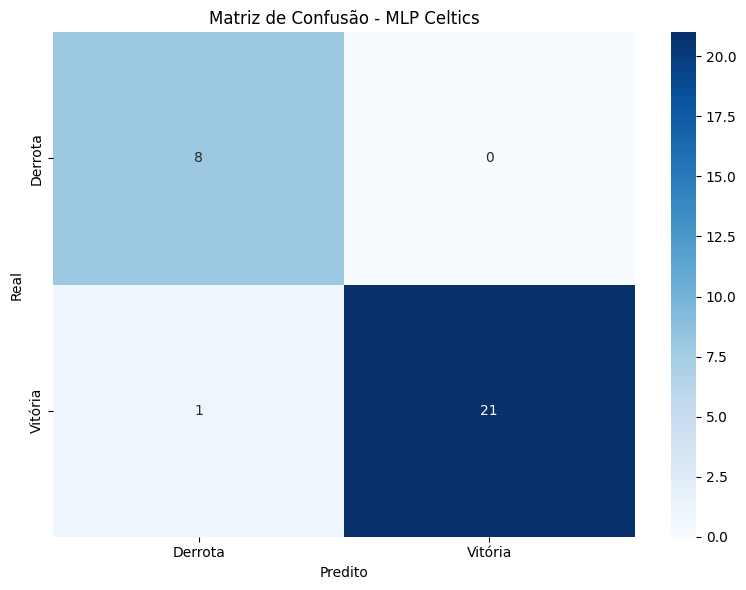

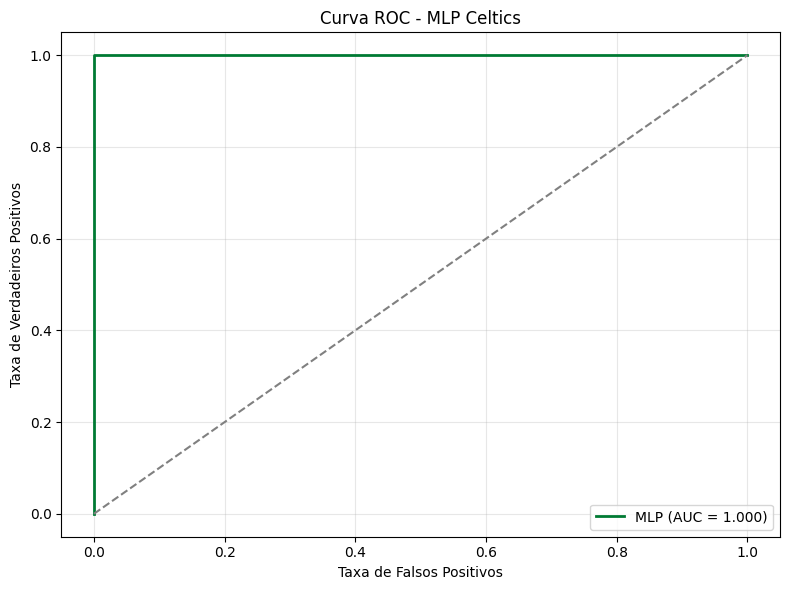

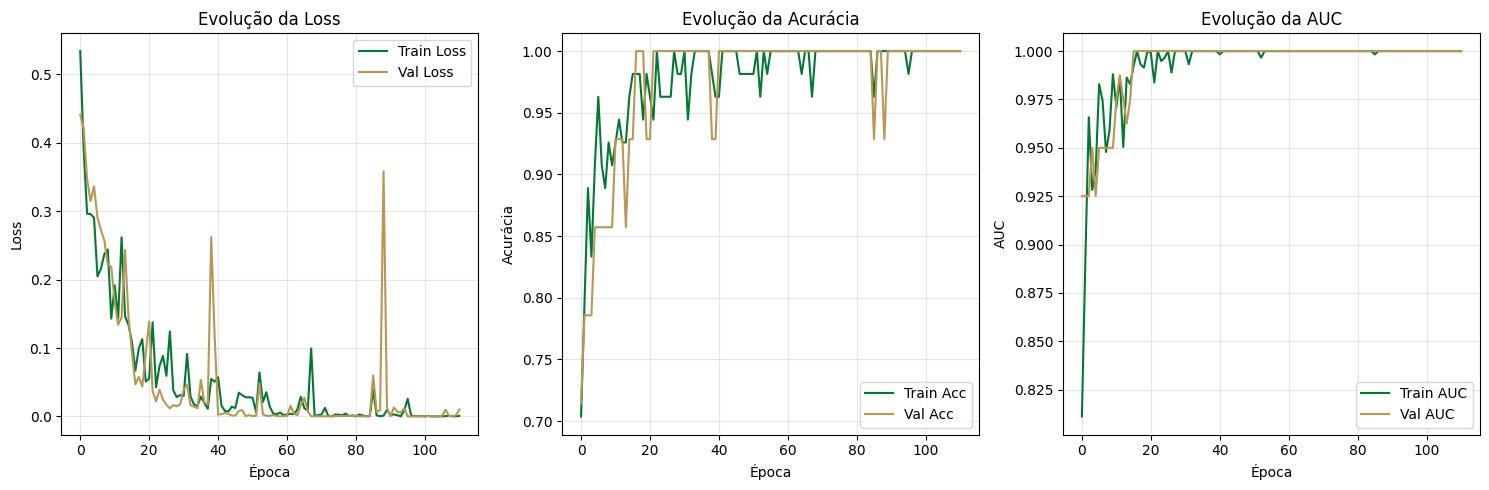


ARQUITETURA DA MLP:
  • Camadas ocultas: 2
  • Neurônios camada 1: 34
  • Neurônios camada 2: 19
  • Função de ativação: elu
  • Optimizer: rmsprop
  • Learning rate: 0.008331
  • Dropout rate: 0.38
  • Batch size: 16

FEATURES SELECIONADAS (10):
   1. Tocos
   2. Cestas de 3 Convertidas
   3. Percentual de Arremesso
   4. Lances Livres Tentados
   5. Local_Encoded
   6. Adversario_Encoded
   7. Pontos
   8. Percentual de Lances Livres
   9. +/-
  10. Assistências

RESULTADOS FINAIS:
  • Acurácia: 0.967
  • Precisão: 1.000
  • Recall: 0.955
  • F1-Score: 0.977
  • AUC-ROC: 1.000
  • MAE: 0.0309
  • RMSE: 0.1678
  • R²: 0.8560


['feature_selection_info.pkl']

In [ ]:
print("\nRELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_test, y_pred, target_names=['Derrota', 'Vitória']))

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Derrota', 'Vitória'],
            yticklabels=['Derrota', 'Vitória'])
plt.title('Matriz de Confusão - MLP Celtics')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.savefig('matriz_confusao_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

# gráfico da curva roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#007A33', linewidth=2, label=f'MLP (AUC = {auc_roc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - MLP Celtics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('curva_roc_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

# evolução do treinamento
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_final.history['loss'], label='Train Loss', color='#007A33')
plt.plot(history_final.history['val_loss'], label='Val Loss', color='#BA9653')
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Acurácia
plt.subplot(1, 3, 2)
plt.plot(history_final.history['accuracy'], label='Train Acc', color='#007A33')
plt.plot(history_final.history['val_accuracy'], label='Val Acc', color='#BA9653')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC
plt.subplot(1, 3, 3)
plt.plot(history_final.history['auc'], label='Train AUC', color='#007A33')
plt.plot(history_final.history['val_auc'], label='Val AUC', color='#BA9653')
plt.title('Evolução da AUC')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evolucao_treinamento_mlp.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nARQUITETURA DA MLP:")
print(f"  • Camadas ocultas: {study_with_fs.best_trial.params['n_layers']}")
for i in range(study_with_fs.best_trial.params['n_layers']):
    print(f"  • Neurônios camada {i+1}: {study_with_fs.best_trial.params[f'n_units_layer_{i}']}")
print(f"  • Função de ativação: {study_with_fs.best_trial.params['activation']}")
print(f"  • Optimizer: {study_with_fs.best_trial.params['optimizer']}")
print(f"  • Learning rate: {study_with_fs.best_trial.params['learning_rate']:.6f}")
print(f"  • Dropout rate: {study_with_fs.best_trial.params['dropout_rate']:.2f}")
print(f"  • Batch size: {study_with_fs.best_trial.params['batch_size']}")

print(f"\nFEATURES SELECIONADAS ({len(best_features)}):")
for i, feature in enumerate(best_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\nRESULTADOS FINAIS:")
print(f"  • Acurácia: {accuracy:.3f}")
print(f"  • Precisão: {precision:.3f}")
print(f"  • Recall: {recall:.3f}")
print(f"  • F1-Score: {f1:.3f}")
print(f"  • AUC-ROC: {auc_roc:.3f}")
print(f"  • MAE: {mae_proba:.4f}")
print(f"  • RMSE: {rmse_proba:.4f}")
print(f"  • R²: {r2_proba:.4f}")

# aualizar informações para salvar
fs_info.update({
    'final_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'mae': mae_proba,
        'rmse': rmse_proba,
        'r2_score': r2_proba
    },
    'test_predictions': {
        'y_true': y_test.values,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba.flatten()
    }
})

# salvar informações atualizadas
joblib.dump(fs_info, 'feature_selection_info.pkl')

In [ ]:
# Salvar previsões para todos os conjuntos (treino, validação, teste) necessárias para os gráficos
def salvar_previsoes_para_graficos(modelo, X_train_fs, X_val_fs, X_test_fs, y_train, y_val, y_test, df, best_features):

    # Fazer previsões para todos os conjuntos
    y_train_pred_proba = modelo.predict(X_train_fs).flatten()
    y_val_pred_proba = modelo.predict(X_val_fs).flatten()
    y_test_pred_proba = modelo.predict(X_test_fs).flatten()

    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    y_test_pred = (y_test_pred_proba > 0.5).astype(int)

    # Criar df com histórico de treinamento
    history_df = pd.DataFrame({
        'epoch': range(1, len(history_final.history['loss']) + 1),
        'train_loss': history_final.history['loss'],
        'val_loss': history_final.history['val_loss'],
        'train_accuracy': history_final.history['accuracy'],
        'val_accuracy': history_final.history['val_accuracy'],
        'train_auc': history_final.history.get('auc', [0]*len(history_final.history['loss'])),
        'val_auc': history_final.history.get('val_auc', [0]*len(history_final.history['loss']))
    })

    history_df.to_csv('historico_treinamento_mlp.csv', index=False)
    previsoes_df = pd.DataFrame({
        'conjunto': (['treino'] * len(y_train)) + (['validacao'] * len(y_val)) + (['teste'] * len(y_test)),
        'y_real': np.concatenate([y_train, y_val, y_test]),
        'y_pred_proba': np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba]),
        'y_pred_binario': np.concatenate([y_train_pred, y_val_pred, y_test_pred])
    })

    previsoes_df.to_csv('previsoes_detalhadas_mlp.csv', index=False)

    # Salvar dados completos com previsões para análise temporal
    df_completo = df.copy()

    return previsoes_df, history_df

previsoes_df, history_df = salvar_previsoes_para_graficos(
    final_model, X_train_fs, X_val_fs, X_test_fs,
    y_train, y_val, y_test, df, best_features
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [ ]:
# Salvar informações completas do modelo para o sistema
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, pd.Timestamp):
        return obj.strftime('%Y-%m-%d %H:%M:%S')
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Salvar informações completas do modelo para o sistema
metadata_modelo = {
    'nome_modelo': 'MLP_Celtics_FeatureSelection',
    'data_treinamento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'arquitetura': {
        'n_layers': study_with_fs.best_trial.params['n_layers'],
        'neurons_por_camada': [study_with_fs.best_trial.params[f'n_units_layer_{i}']
                              for i in range(study_with_fs.best_trial.params['n_layers'])],
        'activation': study_with_fs.best_trial.params['activation'],
        'optimizer': study_with_fs.best_trial.params['optimizer'],
        'learning_rate': float(study_with_fs.best_trial.params['learning_rate']),
        'dropout_rate': float(study_with_fs.best_trial.params['dropout_rate']),
        'batch_size': int(study_with_fs.best_trial.params['batch_size'])
    },
    'features_selecionadas': best_features,
    'metricas_finais': {
        'acuracia': float(accuracy),
        'precisao': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'auc_roc': float(auc_roc),
        'mae': float(mae_proba),
        'rmse': float(rmse_proba),
        'r2_score': float(r2_proba)
    },
    'distribuicao_dados': {
        'total_jogos': int(len(df)),
        'vitorias': int(df['TARGET'].sum()),
        'derrotas': int(len(df) - df['TARGET'].sum()),
        'proporcao_treino_val_test': f"{len(X_train)}/{len(X_val)}/{len(X_test)}"
    },
    'arquivos_gerados': [
        'modelo_mlp_celtics_fs.h5',
        'scaler_mlp.pkl',
        'feature_selection_info.pkl',
        'historico_treinamento_mlp.csv',
        'previsoes_detalhadas_mlp.csv',
        'celtics_2024_25_processado.csv'
    ]
}

# Converter tudo para serializável
metadata_modelo = convert_to_serializable(metadata_modelo)

# Salvar metadata
import json
with open('metadata_modelo_mlp.json', 'w', encoding='utf-8') as f:
    json.dump(metadata_modelo, f, indent=2, ensure_ascii=False)